In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set()

- Skip to [Observations and Discussion](#oad)
- 'NGS-fair_catch.csv' is obtained from: https://www.kaggle.com/jdemeo/preprocessing-ngs

In [2]:
# Load in NGS data, player role data, and play info
ngs_df = pd.read_csv('data/NGS-fair_catch.csv')
play_player_role_df = pd.read_csv('data/play_player_role_data.csv')
play_df = pd.read_csv('data/play_information.csv')

# Merge datasets
ngs_df = pd.merge(ngs_df, play_player_role_df,
                  how="inner",
                  on=['GameKey', 'PlayID', 'GSISID'])

ngs_df = pd.merge(ngs_df, play_df,
                  how="inner",
                  on=['GameKey', 'PlayID'])

# Cleanup
keepers = ['GameKey', 'PlayID', 'GSISID', 'Time', 'x', 'y', 'dis', 'Event', 'Role', 'PlayDescription']
ngs_df = ngs_df[keepers]
ngs_df.head()

,GameKey,PlayID,GSISID,Time,x,y,dis,Event,Role,PlayDescription
0,3,1676,30559.0,2016-08-12 00:45:56.500,18.299999,8.37,0.04,NaN,VLi,(1:51) (Punt formation) S.Waters punts 38 yard...
1,3,1676,30559.0,2016-08-12 00:45:56.600,18.290001,8.33,0.04,NaN,VLi,(1:51) (Punt formation) S.Waters punts 38 yard...
2,3,1676,30559.0,2016-08-12 00:45:56.700,18.270000,8.29,0.04,NaN,VLi,(1:51) (Punt formation) S.Waters punts 38 yard...
3,3,1676,30559.0,2016-08-12 00:45:56.800,18.280001,8.21,0.08,NaN,VLi,(1:51) (Punt formation) S.Waters punts 38 yard...
4,3,1676,30559.0,2016-08-12 00:45:56.900,18.270000,8.17,0.04,NaN,VLi,(1:51) (Punt formation) S.Waters punts 38 yard...


In [3]:
# NGS Unique_ids
ngs_ids = ngs_df.groupby(['GameKey','PlayID']).size().reset_index().rename(columns={0:'count'})
ngs_ids.shape

(1657, 3)

### Goal: find the proximity of the nearest punt player to the PR when a fair catch is called.
- I am interested in this distribution because it will give me an idea at what distance the PR might be deciding to except a fair catch. This helps to understand their decision making and wether a PR restricted zone of 8 yards would have negated a fair catch. 
- I will use the event 'fair catch' to get the approximate distances from the PR.

In [4]:
'''ONLY RUN THE FOLLOWING TWO BLOCKS TO GET AN IDEA OF THE COURSE OF EVENTS FOR A PARTICULAR PLAY'''

# def isolate_play(df, game_key, play_id):
#     '''Create a dataframe of a particular play'''
#     where_condition = ((df['GameKey'] == game_key) &
#                        (df['PlayID'] == play_id))
#     new_df = df[where_condition].copy()
#     new_df.sort_values(by=['Time'], inplace=True)
#     new_df.reset_index(drop=True, inplace=True)
#     return new_df

# def course_of_events(df):
#     '''Get list of events in order of occurrence for a particular play'''
#     events = []
#     for i in range(len(df)):
#         event = df.loc[i, 'Event']
#         if event not in events:
#             events.append(event)
           
#     print('Play Description:', df.loc[0, 'PlayDescription'])
#     print('---')
#     print('Game Events:', events)
#     print('-----------------------------------------------')

'ONLY RUN THE FOLLOWING TWO BLOCKS TO GET AN IDEA OF THE COURSE OF EVENTS FOR A PARTICULAR PLAY'

In [5]:
# # Iterate through ids to get events for each play
# for i in range(len(ngs_ids)):
#     game_key = ngs_ids.loc[i, 'GameKey']
#     play_id = ngs_ids.loc[i, 'PlayID']
#     the_play = isolate_play(ngs_df, game_key, play_id)
#     course_of_events(the_play)

- Looking at the course of events during a play, 'fair_catch' seems like a reasonable place to see proximity of oponnent players

In [6]:
def event_df_creation(df, event):
    '''Get a new dataframe with data pertinent to a particular event'''
    new_df = df[df['Event'] == event].reset_index(drop=True)
    unique_ids = new_df.groupby(['GameKey','PlayID']).size().reset_index().rename(columns={0:'count'})
    return new_df, unique_ids

In [7]:
# Let's indicate what team the player is playing on based off player role
return_team_positions = ['PR', 'PDL1', 'PDL2', 'PDL3', 'PDL4', 'PDR1', 'PDR2', 'PDR3', 'PDR4', 'VL', 'VR', 
                         'PLL', 'PLR', 'VRo', 'VRi', 'VLi', 'VLo', 'PLM', 'PLR1', 'PLR2', 'PLL1', 'PLL2',
                         'PFB', 'PDL5', 'PDR5', 'PDL6', 'PLR3', 'PLL3', 'PDR6', 'PLM1', 'PDM']
punt_team_positions = ['P', 'PLS', 'PPR', 'PLG', 'PRG', 'PLT', 'PRT', 'PLW', 'PRW', 'GL', 'GR',
                       'GRo', 'GRi', 'GLi', 'GLo', 'PC', 'PPRo', 'PPRi', 'PPL', 'PPLi', 'PPLo']

def label_team(df):
    '''Label each player by the team they play on'''
    df['team'] = ''
    print('Determining player roles')

    for i, role in enumerate(df['Role']):
        if role in return_team_positions:
            df.loc[i, 'team'] = 'return team'
        elif role in punt_team_positions:
            df.loc[i, 'team'] = 'punt team'
        else:
            df.loc[i, 'team'] = 'unknown'

In [8]:
def calculate_player_proximity(role_x, role_y, player_x, player_y):
    '''Calculate euclidean distance between two players'''
    leg_x = (role_x - player_x) ** 2
    leg_y = (role_y - player_y) ** 2
    hypotenuse = np.sqrt(leg_x + leg_y)
    return hypotenuse

In [9]:
def calculate_x_proximity(role_x, player_x):
    '''Calculate distance of a player to a particular role only by yardline'''
    return np.abs(role_x - player_x)

In [10]:
def calculate_proximity_for_play(df, unique_ids, role):
    '''Calculate proximity of each player to the player of a particular role'''
    # Create feature for player proximity
    df['proximity_to_' + role + '_circle'] = 0
    df['proximity_to_' + role + '_x'] = 0
    
    print('Calculating player proximities to', role)
    
    # Go through each data point in particular NGS dataset
    for i in range(len(df)):
        
        # Play Information
        game_key = df.loc[i, 'GameKey']
        play_id = df.loc[i, 'PlayID']
        
        # Get one unique set of data points related to a single (GameKey, PlayID) pair
        where_condition = ((df['GameKey'] == game_key) &\
                           (df['PlayID'] == play_id))
        just_view = df[where_condition].reset_index()
        
        # Get coordinates of a player with a particular role
        if any(just_view['Role'] == role):
            role_x = just_view.loc[just_view['Role'] == role, 'x'].values[0]
            role_y = just_view.loc[just_view['Role'] == role, 'y'].values[0]
            
        # Plays that don't actually have the particular role represented
        else:
            continue

        # Current Player coordinates
        position_x = df.loc[i, 'x']
        position_y = df.loc[i, 'y']

        # Calculate proximity
        proximity_hypo = calculate_player_proximity(role_x, role_y, position_x, position_y)
        proximity_x = calculate_x_proximity(role_x, position_x)
        df.loc[i, 'proximity_to_' + role + '_circle'] = proximity_hypo
        df.loc[i, 'proximity_to_' + role + '_x'] = proximity_x

In [11]:
def calculate_closest_player(df, unique_ids, column):
    '''Find who the closest player on the punt team is and create new id set'''
    unique_ids[column] = 0
    good_indexes = []
    role = 'PR'
    print('Determining closest player to', role)
    
    for i in range(len(unique_ids)):
        
        # Play information
        game_key = unique_ids.loc[i, 'GameKey']
        play_id = unique_ids.loc[i, 'PlayID']

        # Get one unique set of data points related to a single (GameKey, PlayID) pair
        where_condition = ((df['GameKey'] == game_key) &\
                           (df['PlayID'] == play_id) &\
                           (df['team'] == 'punt team'))
        just_view = df[where_condition].reset_index(drop=True)
        
        # Take minimum of series and Error handling where the NGS data had no punt team :(
        try:
            unique_ids.loc[i, column] = min(just_view[column])
            good_indexes.append(i)
        except ValueError:
            continue
    
    # Create new set of ids
    new_ids = unique_ids.loc[good_indexes, :].copy()
    new_ids.reset_index(inplace=True, drop=True)
    
    return new_ids

### Goal: Want to look at the closest punt player's proximity when the ball is fair caught
- Workflow:
    - Get datapoints for a particular plays event
    - Label the players by what team they are
    - Calculate each players proximity to a particular role
    - Find the minimum distance from punt player to PR
    - Return those proximities for each play

In [18]:
event_df, event_ids = event_df_creation(ngs_df, 'fair_catch')
label_team(event_df)
calculate_proximity_for_play(event_df, event_ids, 'PR')
new_ids = calculate_closest_player(event_df, event_ids, 'proximity_to_PR_circle')
new_ids = calculate_closest_player(event_df, new_ids, 'proximity_to_PR_x')
new_ids.to_csv('data/FC-proximity.csv', index=False)

Determining player roles
Calculating player proximities to PR
Determining closest player to PR
Determining closest player to PR


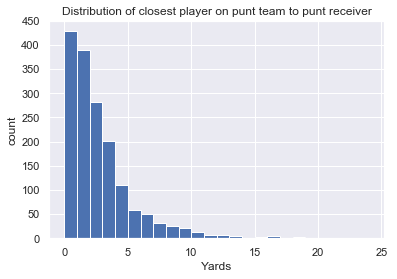

count    1637.000000
mean        2.723213
std         2.640359
min         0.000000
25%         0.949997
50%         2.000000
75%         3.560001
max        19.650002
Name: proximity_to_PR_x, dtype: float64

In [13]:
'''Plot of distribution distance of closest punt team player to punt receiver'''
bins = [i for i in range(0, 25, 1)]
plt.hist(new_ids['proximity_to_PR_x'], bins=bins)

plt.title('Distribution of closest player on punt team to punt receiver')
plt.xlabel('Yards')
plt.ylabel('count')
plt.show()

new_ids['proximity_to_PR_x'].describe()

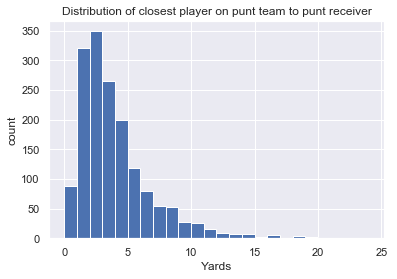

count    1637.000000
mean        4.037048
std         3.045901
min         0.000000
25%         2.000252
50%         3.191694
75%         5.040604
max        24.298479
Name: proximity_to_PR_circle, dtype: float64

In [14]:
'''Plot of distribution distance of closest punt team player to punt receiver'''
bins = [i for i in range(0, 25, 1)]
plt.hist(new_ids['proximity_to_PR_circle'], bins=bins)

plt.title('Distribution of closest player on punt team to punt receiver')
plt.xlabel('Yards')
plt.ylabel('count')
plt.show()

new_ids['proximity_to_PR_circle'].describe()

## <a id="oad">Observations and Discussion</a>
- Average of the closest punt team player to the PR yardline distance: 2.72 yards
- Average of the closest punt team player to the PR Euclidean distance: 4.04 yards

In [15]:
print('Count of fair catches with punt team player greater than 8 yards away by yardline:',
      new_ids[new_ids['proximity_to_PR_x'] > 8].shape[0])
print('Count of fair catches with punt team player greater than 8 yards away by Euclidean distance:',
      new_ids[new_ids['proximity_to_PR_circle'] > 10].shape[0])

Count of fair catches with punt team player greater than 8 yards away by yardline: 86
Count of fair catches with punt team player greater than 8 yards away by Euclidean distance: 83


- Given a PR restricted zone of 8 yards by yardline and 10 yards by euclidean distance:
    - **Yardline distance**: 86 of 1637 -> 5.25% of fair catches
    - **Euclidean distance**: 83 of 1637 -> 5.07% of fair catches
- **~95% of fair catches** occur when a punt team player is within the above yardline cutoffs
    - I'd assume that these fair catches are called in a large part due to proximity of a punt team player so by providing a restricted zone for the PR, a fair catch is far less likely to occur as only about 5% of the time is a fair catch called further out then this proposed restricted zone

## Graphic of proximities for fair catch and punt returns
- **PR-proximity.csv** can be obtained from: https://www.kaggle.com/jdemeo/analysis-punt-returns
- **FC-proximity.csv** is produce in this notebook

In [19]:
pr_proximity = pd.read_csv('data/PR-proximity.csv')
pr_proximity.head()

,GameKey,PlayID,count,proximity_to_PR_circle,proximity_to_PR_x
0,3,455,22,7.248727,7.120003
1,3,1542,21,1.998125,0.730001
2,4,927,22,5.117831,4.889999
3,4,1725,20,16.594451,15.660004
4,4,2888,22,13.772817,12.639999


In [20]:
fc_proximity = pd.read_csv('data/FC-proximity.csv')
fc_proximity.head()

,GameKey,PlayID,count,proximity_to_PR_circle,proximity_to_PR_x
0,3,1676,22,0.894932,0.220001
1,4,291,21,4.669017,1.090004
2,4,1056,22,1.961250,0.070000
3,4,1618,22,2.199659,0.360001
4,5,3521,22,2.015465,0.869995


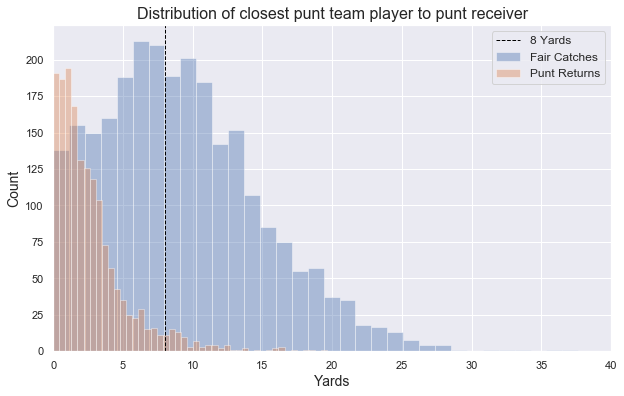

In [22]:
plt.figure(figsize=(10, 6))
sns.distplot(pr_proximity['proximity_to_PR_x'], kde=False)
sns.distplot(fc_proximity['proximity_to_PR_x'], kde=False)
plt.axvline(8, color='black', linestyle='dashed', linewidth=1)

plt.xlim(0, 40)
plt.legend(['8 Yards', 'Fair Catches', 'Punt Returns'], fontsize=12)
plt.title('Distribution of closest punt team player to punt receiver', fontsize=16)
plt.xlabel('Yards', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.savefig('figures/fc_pr_distributions.png', bbox_inches='tight')
plt.show()

# Links to other notebooks:
- Concussion play analysis with proposed rule changes: https://www.kaggle.com/jdemeo/analysis-concussions
- Analysis of uncalled penalties: https://www.kaggle.com/jdemeo/analysis-uncalled-penalties
- Analysis of punt returns: https://www.kaggle.com/jdemeo/analysis-punt-returns
- Preprocessing of Play Information: https://www.kaggle.com/jdemeo/preprocessing-punt-play
- Preprocessing of NGS data for the above notebooks: https://www.kaggle.com/jdemeo/preprocessing-ngs